# Financial News - Preprocessing for word2vec

this nb parses financial news data into sentences and then detects phrases as 2 and 3 grams

See notebook [lda_financial_news](../15_topic_modeling/07_financial_news/lda_financial_news.ipynb) for download instructions.

## Imports

In [1]:
import os, tarfile, sys, json
from pathlib import Path
from time import time
from pprint import pprint
from collections import Counter

import numpy as np
from numpy.random import choice
import pandas as pd
import seaborn as sns

import spacy
from spacy.lang.en import English

from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

### Settings

In [2]:
pd.set_option('float_format', '{:,.2f}'.format)
sns.set_style('white')
np.random.seed(42)

In [3]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

In [4]:
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',
                             header=None,
                             squeeze=True).tolist())

### Paths

In [5]:
data_path = Path('..', 'data', 'us-financial-news')

In [9]:
data_path

PosixPath('../data/us-financial-news')

In [8]:
results_path  #in nb folder

PosixPath('results/financial_news')

In [10]:
results_path = Path('results', 'financial_news')
if not results_path.exists():
    results_path.mkdir(exist_ok=True)

In [11]:
article_path = results_path / 'articles.txt'
clean_article_path = results_path / 'articles_clean.txt'

## Load Data

In [12]:
section_titles = ['Press Releases - CNBC',
                  'Reuters: Company News',
                  'Reuters: World News',
                  'Reuters: Business News',
                  'Reuters: Financial Services and Real Estate',
                  'Top News and Analysis (pro)',
                  'Reuters: Top News',
                  'The Wall Street Journal &amp; Breaking News, Business, Financial and Economic News, World News and Video',
                  'Business &amp; Financial News, U.S &amp; International Breaking News | Reuters',
                  'Reuters: Money News', 'Reuters: Technology News']

In [14]:
def read_articles():
    articles = []
    counter = Counter()
    for f in data_path.glob('*/**/*.json'):
        article = json.load(f.open())
        if article['thread']['section_title'] in set(section_titles):
            text = article['text'].lower().split()
            counter.update(text)
            articles.append(' '.join([t for t in text if t not in stop_words]))
    return articles, counter

In [15]:
articles, counter = read_articles()
print(f'Done loading {len(articles):,.0f} articles')

Done loading 125,964 articles


In [32]:
len(articles[0])  # first doc length

1075

In [34]:
articles[0]  # first doc

'17 hours ago | 02:56 emerging markets soared 33 percent 2017, todd gordon tradinganalysis.com says rally won\'t stop. big rally emerging markets, tracked emerging market etf eem , weak dollar. given gordon sees inverse relationship eem dollar, measured charts dollar-tracking etf uup , believes u.s. currency continue help group. "we falling u.s. dollar, support international emerging market currencies eem stocks boost," gordon said tuesday cnbc\'s "trading nation." u.s. dollar 2017 posted worst annual performance 14 years, eem saw best performance 2013. high go, gordon says eem broken "resistance" $45, etf\'s 2014 highs. $45 region calls "support," sees rallying $50, etf hasn\'t hit mid-2011. play higher, gordon suggested buying february 48/50 spread 72 cents, $72 options contract. means eem closes $50 feb. 16, gordon make maximum reward $128 trade. eem close $48, gordon lose $72 paid trade. result, gordon wants establish point out. "if 72 cent premium just laid gets cut half 36 cents,

In [31]:
article_path

PosixPath('results/financial_news/articles.txt')

In [35]:
article_path.write_text('\n'.join(articles))

418422851

## Clean Financial News Articles

In [10]:
articles = article_path.read_text().split('\n')
len(articles)

125964

### Sentence Boundary Detection

In [19]:
def clean_doc(d, min_sent_len=5, max_sent_len=100):
    """
    each document is splited in sentences.
    every token in each sentence is lowercased and added only if is_alpha
    return: a list containing in each element a cleaned sentence
    """
    doc = []
    for sent in d.sents:
        s = [t.text.lower() for t in sent if not
            any([t.is_digit, not t.is_alpha, t.is_punct, t.is_space])]
        if len(s) > min_sent_len or len(sent) < max_sent_len:
            doc.append(' '.join(s))
    return doc

In [30]:
clean_doc(nlp("I am a Data Scientist! I am interested in trading"))

['i am a data scientist', 'i am interested in trading']

In [20]:
nlp = English()
sentencizer = nlp.create_pipe("sentencizer")  # built-in pipeline component to Add rule-based sentence segmentation without the dependency parse.
nlp.add_pipe(sentencizer)

In [21]:
nlp.pipe_names

['sentencizer']

In [22]:
clean_articles = []
iter_articles = (article for article in articles)
for i, doc in enumerate(nlp.pipe(iter_articles, batch_size=100, n_process=8), 1):
    if i % int(len(articles) / 100) + 1 == 0:
        print(f'{i / len(articles):.1%}', end=' ', flush=True)
    clean_articles.extend(clean_doc(doc))

In [23]:
clean_article_path.write_text('\n'.join(clean_articles))

356650931

In [40]:
articles[0][:200]

"17 hours ago | 02:56 emerging markets soared 33 percent 2017, todd gordon tradinganalysis.com says rally won't stop. big rally emerging markets, tracked emerging market etf eem , weak dollar. given go"

In [36]:
clean_articles[0]  # first sentence on first article

'hours ago emerging markets soared percent todd gordon says rally wo stop'

### Corpus Stats

In [41]:
len(clean_articles)   # total number of sentences on each article

2986105

In [42]:
vocab = Counter()
sent_length = []
for sentence in clean_articles:
    tokens = sentence.lower().split()
    sent_length.append(len(tokens))
    vocab.update(tokens)

In [43]:
len(sent_length)

2986105

In [44]:
pd.Series(sent_length).describe(percentiles=np.arange(.1, 1, .1).round(1))

count   2,986,105.00
mean           15.36
std            20.68
min             0.00
10%             4.00
20%             6.00
30%             8.00
40%            10.00
50%            12.00
60%            14.00
70%            17.00
80%            20.00
90%            25.00
max         6,910.00
dtype: float64

2.986 M sentences, on average 15 tokens length

In [45]:
most_common = (pd.DataFrame(vocab.most_common(), columns=['token', 'count'])
               .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]))

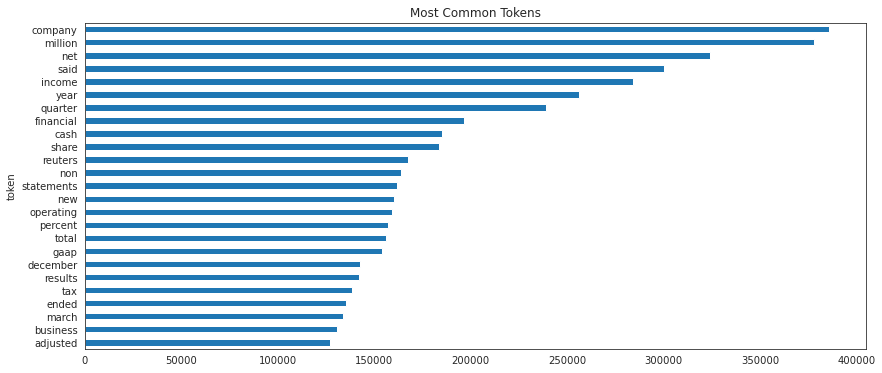

In [46]:
most_common.head(25).set_index('token')['count'].sort_values().plot.barh(title='Most Common Tokens', figsize=(14, 6));

### Inspect Result

In [47]:
clean_articles[:3]

['hours ago emerging markets soared percent todd gordon says rally wo stop',
 'big rally emerging markets tracked emerging market etf eem weak dollar',
 'given gordon sees inverse relationship eem dollar measured charts dollar tracking etf uup believes']

## Create n-grams

In [51]:
max_length = 3

In [52]:
n_grams = pd.DataFrame()
start = time()
sentences = LineSentence(clean_article_path.as_posix())  # stream sentences 
for n in range(2, max_length + 1):
    print(n, end=' ')
    if n>2:
        sentences = LineSentence((results_path / f'articles_{n-1}_grams.txt').as_posix())
    phrases = Phrases(sentences, threshold=100, min_count=10)  # 

    s = pd.Series({k.decode('utf-8'): v for k,
                   v in phrases.export_phrases(sentences)}) 
    s = s.to_frame('score').reset_index().rename(
        columns={'index': 'phrase'}).assign(length=n)

    n_grams = pd.concat([n_grams, s])
    grams = Phraser(phrases)
    sentences = grams[sentences]

    with (results_path / f'articles_{n}_grams.txt').open('w') as f:
        # articles with 2-grams and 3-grams phrases coalesced with "_" are writen
        # in 05_financial_news_word_
        for sentence in sentences:
            f.write(' '.join(sentence) + '\n')

n_grams = n_grams.sort_values('score', ascending=False)
n_grams.phrase = n_grams.phrase.str.replace('_', ' ')
n_grams['ngram'] = n_grams.phrase.str.replace(' ', '_')

print('\n\tDuration: ', format_time(time() - start))
print(f'\tngrams: {len(n_grams):,d}\n')
print(n_grams.groupby('length').size())

2 3 
	Duration:  00:37:44
	ngrams: 43,678

length
2    26965
3    16713
dtype: int64


In [53]:
n_grams.groupby('length').apply(lambda x: x.nlargest(10, 'score'))

phrase      score  length  \
length                                                                 
2      10898                pracha hariraksapitak 182,360.93       2   
       17090                        citigate dewe 182,360.93       2   
       12373             hidradenitis suppurativa 182,360.93       2   
       23226           mukhammadsharif mamatkulov 182,360.93       2   
       26622                         nidaa tounes 181,947.41       2   
       19173                      koustav samanta 181,947.41       2   
       24782                     navesh chitrakar 181,947.41       2   
       21854               axalimogene filolisbac 181,947.41       2   
       25250              munkhchimeg davaasharav 181,855.77       2   
       7599                          krispy kreme 181,855.77       2   
3      3351   daniela palmieri jessica fitzgerald 189,347.18       3   
       5395    strategist janney montgomery scott 189,347.18       3   
       14148                 dana reizniece ozola 189,347.18       3   
       7500           hgst sandisk tegile upthere 189,347.18       3   
       8466              writing fransiska nangoy 189,347.18       3   
       13693       carson elder beerman herberger 189,347.18       3   
       13547       freshfields bruckhaus deringer 189,347.18       3   
       4843               spokesman baik tae hyun 188,917.82       3   
       16038  guesthouse meseberg palace meseberg 188,917.82       3   
       13123                   castello di casole 188,917.82       3   

                                            ngram  
length                                             
2      10898                pracha_hariraksapitak  
       17090                        citigate_dewe  
       12373             hidradenitis_suppurativa  
       23226           mukhammadsharif_mamatkulov  
       26622                         nidaa_tounes  
       19173                      koustav_samanta  
       24782                     navesh_chitrakar  
       21854               axalimogene_filolisbac  
       25250              munkhchimeg_davaasharav  
       7599                          krispy_kreme  
3      3351   daniela_palmieri_jessica_fitzgerald  
       5395    strategist_janney_montgomery_scott  
       14148                 dana_reizniece_ozola  
       7500           hgst_sandisk_tegile_upthere  
       8466              writing_fransiska_nangoy  
       13693       carson_elder_beerman_herberger  
       13547       freshfields_bruckhaus_deringer  
       4843               spokesman_baik_tae_hyun  
       16038  guesthouse_meseberg_palace_meseberg  
       13123                   castello_di_casole